## IDs:
ID 1: 204502926 <br>
ID 2: 039065313

## Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
folder='./ml-100k/'

In [3]:
item_col = ['item_id','movie title','release date','video release date','IMDb URL','unknown','Action','Adventure','Animation',
              'Children','Comedy','Crime','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
movie_df = pd.read_csv(folder+"u.item",sep='|',encoding='ISO-8859-1',names=item_col)

# column_names = ['user_id', 'item_id', 'rating', 'timestamp']
# ratings = pd.read_csv(folder+'ua.base',sep='\t',names=column_names) 
# sep cannot infer '\t' from files so explicitly supply arg
# ratings.info()

names = ['user_id', 'item_id', 'rating', 'timestamp']
folder = "./ml-100k/"
data_df = pd.read_csv(folder+'u.data', sep='\t', names=names)
data_df.head()

user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

In [4]:
# pd.pivot_table(data_df, values='rating', index=['item_id'], columns = ['user_id']).fillna(0)

In [5]:
n_users = data_df.user_id.unique().shape[0]
n_items = data_df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in data_df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [6]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()

    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train_ratings, test_ratings = train_test_split(ratings)

# Question 1: Item Similarity (40 points)

#### a. Build a movie profile vector based on the item features of your choice. Suggested options: item genres

In [13]:
movie_profile_df = movie_df[['item_id','Action','Adventure','Animation',
              'Children','Comedy','Crime','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']].set_index('item_id')
movie_profile_df.sort_index(axis=0, inplace=True)

movie_profile_df.head()

Action  Adventure  Animation  Children  Comedy  Crime  Documentary  \
item_id                                                                       
1             0          0          1         1       1      0            0   
2             1          1          0         0       0      0            0   
3             0          0          0         0       0      0            0   
4             1          0          0         0       1      0            0   
5             0          0          0         0       0      1            0   

         Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  \
item_id                                                                         
1            0        0          0       0        0        0        0       0   
2            0        0          0       0        0        0        0       0   
3            0        0          0       0        0        0        0       0   
4            1        0          0       0        0        0        0       0   
5            1        0          0       0        0        0        0       0   

         Thriller  War  Western  
item_id                          
1               0    0        0  
2               1    0        0  
3               1    0        0  
4               0    0        0  
5               1    0        0

#### b. Build a function which provides the 5 most similar items to a specific item. Item to item similarity is calculated using the cosine similarity metric.

In [14]:
cosine_similarity_item_item = cosine_similarity(movie_profile_df, movie_profile_df)

In [15]:
def check_for_similarity(item_id, item_ids_to_compare, df):
#     flag = True
    
    for item_id_to_compare in item_ids_to_compare:
        matched, not_matched = 0, 0
        print(f"Compare item_id:{item_id} & item_id:{item_id_to_compare}")
        for ((columnNameA, columnDataA), (columnNameB, columnDataB)) in zip(df.loc[[item_id]].iteritems(), df.loc[[item_id_to_compare]].iteritems()):
        #     print(f'Colunm Name: {columnNameA} genere: {columnDataA.values}, {columnDataB.values}')
            if columnDataA.values != columnDataB.values:
#                 print(f'--> Colunm Name: {columnNameA}, {item_id}: {columnDataA.values}, {item_id_to_compare}: {columnDataB.values}. mistmatch')
#                 flag = False
                not_matched += 1
            else:
#                 print(f'Colunm Name: {columnNameA}, {item_id}: {columnDataA.values}, {item_id_to_compare}: {columnDataB.values}. match')
                matched += 1
        print(f"Matched/Not Matched: {matched}/{not_matched}")
        print("-------------------\n")

    #             
#     return flag

In [18]:
def predict_most_similar_items_per_movie(cosine_similarity_matrix, profile_A_df, profile_B_df, item_id, num_items=5, exclude_if_item_match=True):
    result = np.argsort(cosine_similarity_matrix[profile_A_df.index.get_loc(item_id),:])[::-1][:num_items+1]
    
    if exclude_if_item_match:
        ret_result = [profile_B_df.index[i] for i in result if profile_B_df.index[i] != item_id]
    else:
        ret_result = [profile_B_df.index[i] for i in result]
    
    if len(ret_result) > num_items:
        ret_result = ret_result[:num_items]
    
    return ret_result


item_id = 5
predict_most_similar_items_per_movie(cosine_similarity_item_item, movie_profile_df, movie_profile_df, item_id)

[348, 1213, 329, 332, 1208]

#### c. Use the above function to find most similar items for 2 items from the dataset. Explain your results.

In [19]:
movie_id_1 = 1
movie_id_2 = 2

### 1. Item-2-Item Similarity results

In [20]:
result_for_movie_id_1 = predict_most_similar_items_per_movie(cosine_similarity_item_item, movie_profile_df, movie_profile_df, movie_id_1)

result_for_movie_id_2 = predict_most_similar_items_per_movie(cosine_similarity_item_item, movie_profile_df, movie_profile_df, movie_id_2)

print(f"Comparing: {movie_id_1} & {result_for_movie_id_1}\n")
check_for_similarity(movie_id_1, result_for_movie_id_1, movie_profile_df)
print("\n#############################\n\n")
print(f"Comparing: {movie_id_2} & {result_for_movie_id_2}\n")
check_for_similarity(movie_id_2, result_for_movie_id_2, movie_profile_df)

Comparing: 1 & [422, 95, 1219, 243, 261]

Compare item_id:1 & item_id:422
Matched/Not Matched: 18/0
-------------------

Compare item_id:1 & item_id:95
Matched/Not Matched: 17/1
-------------------

Compare item_id:1 & item_id:1219
Matched/Not Matched: 17/1
-------------------

Compare item_id:1 & item_id:243
Matched/Not Matched: 17/1
-------------------

Compare item_id:1 & item_id:261
Matched/Not Matched: 17/1
-------------------


#############################


Comparing: 2 & [118, 827, 1016, 1013, 566]

Compare item_id:2 & item_id:118
Matched/Not Matched: 18/0
-------------------

Compare item_id:2 & item_id:827
Matched/Not Matched: 18/0
-------------------

Compare item_id:2 & item_id:1016
Matched/Not Matched: 18/0
-------------------

Compare item_id:2 & item_id:1013
Matched/Not Matched: 18/0
-------------------

Compare item_id:2 & item_id:566
Matched/Not Matched: 18/0
-------------------



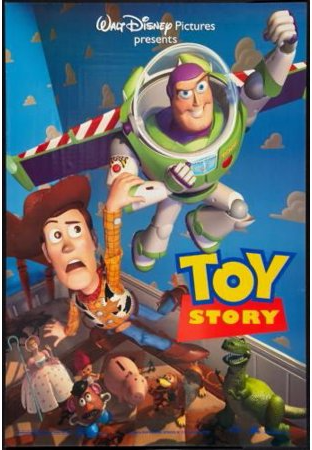

In [21]:
movie_df[movie_df.item_id.isin([1])][['item_id', 'movie title']]

item_id       movie title
0        1  Toy Story (1995)

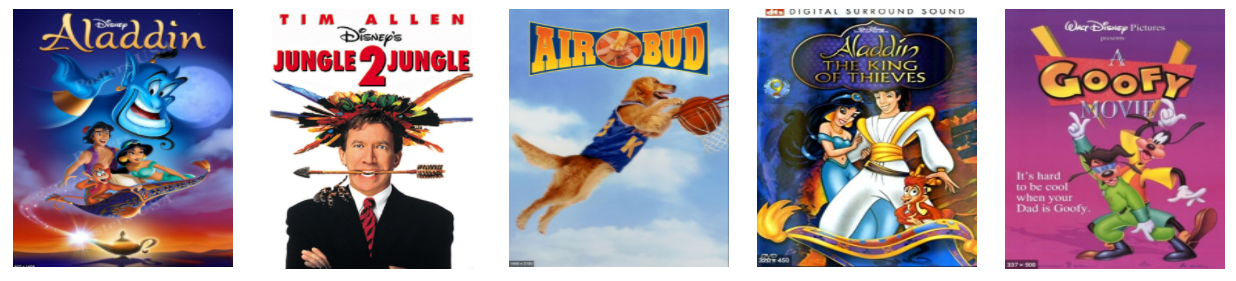

In [22]:
movie_df[movie_df.item_id.isin(result_for_movie_id_1)][['item_id', 'movie title']]

item_id                             movie title
94         95                          Aladdin (1992)
242       243                    Jungle2Jungle (1997)
260       261                          Air Bud (1997)
421       422  Aladdin and the King of Thieves (1996)
1218     1219                   Goofy Movie, A (1995)

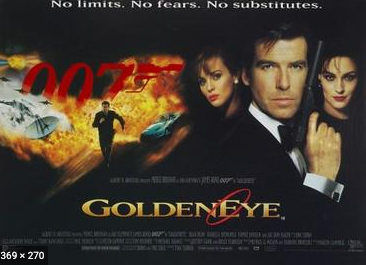

In [23]:
movie_df[movie_df.item_id.isin([2])][['item_id', 'movie title']]

item_id       movie title
1        2  GoldenEye (1995)

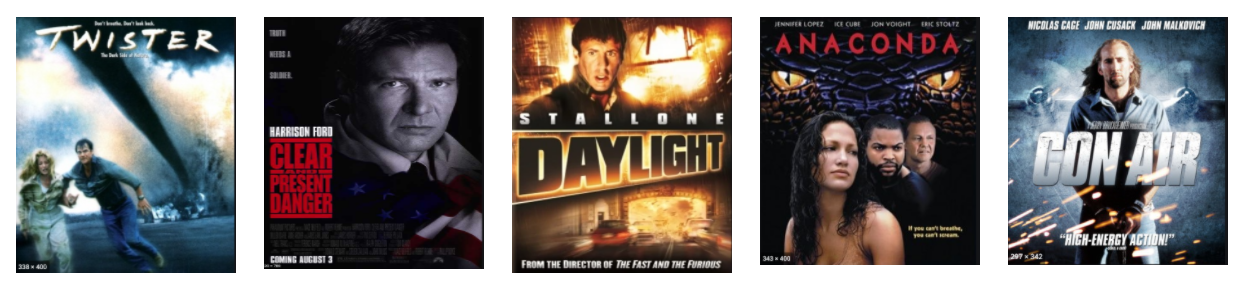

In [24]:
movie_df[movie_df.item_id.isin(result_for_movie_id_2)][['item_id', 'movie title']]

item_id                      movie title
117       118                   Twister (1996)
565       566  Clear and Present Danger (1994)
826       827                  Daylight (1996)
1012     1013                  Anaconda (1997)
1015     1016                   Con Air (1997)

#### d. Use the matrix factorization item representation you built in exercise 1 to find the most similar items for the same 2 items you used above. Compare between the results.

##### Answer
Our steps:
* "1. Item-2-Item Similarity results" (previous question) - We ran the Item Similarity on the movies' genres and showed the results.
* "2. Matrix Factorization results" - We took the vector we calculated in Homework1 and ran the cosine similarity on the latent factor (k=20) again.
* "3. Talk about the results".

#### 2. Matrix Factorization results

In [25]:
import pickle

with open('./sgd_item_vecs.pkl', 'rb') as f:
    item_vecs = pickle.load(f)

item_vecs_df = pd.DataFrame(item_vecs, index=[i for i in range(1, item_vecs.shape[0] + 1)])

cosine_similarity_MF_item_item = cosine_similarity(item_vecs_df, item_vecs_df)

result_for_movie_id_1 = predict_most_similar_items_per_movie(cosine_similarity_MF_item_item, item_vecs_df, item_vecs_df, movie_id_1)

result_for_movie_id_2 = predict_most_similar_items_per_movie(cosine_similarity_MF_item_item, item_vecs_df, item_vecs_df, movie_id_2)

print(f"Comparing: {movie_id_1} & {result_for_movie_id_1}\n")
check_for_similarity(movie_id_1, result_for_movie_id_1, movie_profile_df)
print("\n#############################\n\n")
print(f"Comparing: {movie_id_2} & {result_for_movie_id_2}\n")
check_for_similarity(movie_id_2, result_for_movie_id_2, movie_profile_df)

FileNotFoundError: [Errno 2] No such file or directory: './sgd_item_vecs.pkl'

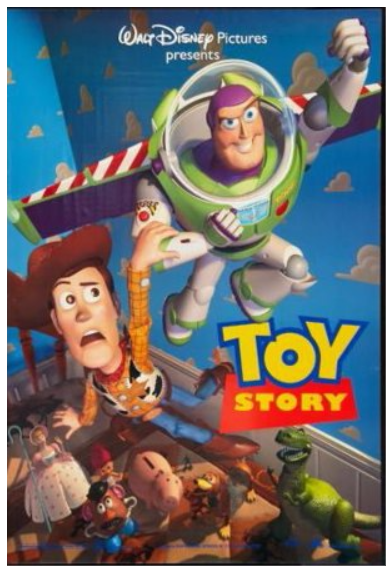

In [26]:
movie_df[movie_df.item_id.isin([1])]

item_id       movie title release date  video release date  \
0        1  Toy Story (1995)  01-Jan-1995                 NaN   

                                            IMDb URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   

   Adventure  Animation  Children  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1         1  ...        0          0       0        0   

   Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0       0         0    0        0  

[1 rows x 24 columns]

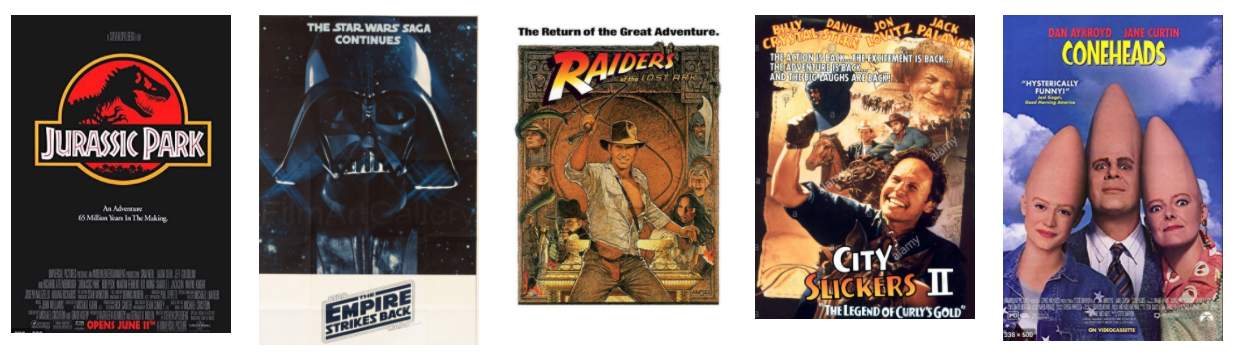

In [19]:
movie_df[movie_df.item_id.isin([577, 174, 82, 575, 172])]

item_id                                        movie title release date  \
81        82                               Jurassic Park (1993)  01-Jan-1993   
171      172                    Empire Strikes Back, The (1980)  01-Jan-1980   
173      174                     Raiders of the Lost Ark (1981)  01-Jan-1981   
574      575  City Slickers II: The Legend of Curly's Gold (...  01-Jan-1994   
576      577                                   Coneheads (1993)  01-Jan-1993   

     video release date                                           IMDb URL  \
81                  NaN  http://us.imdb.com/M/title-exact?Jurassic%20Pa...   
171                 NaN  http://us.imdb.com/M/title-exact?Empire%20Stri...   
173                 NaN  http://us.imdb.com/M/title-exact?Raiders%20of%...   
574                 NaN  http://us.imdb.com/M/title-exact?City%20Slicke...   
576                 NaN  http://us.imdb.com/M/title-exact?Coneheads%20(...   

     unknown  Action  Adventure  Animation  Children  ...  Fantasy  Film-Noir  \
81         0       1          1          0         0  ...        0          0   
171        0       1          1          0         0  ...        0          0   
173        0       1          1          0         0  ...        0          0   
574        0       0          0          0         0  ...        0          0   
576        0       0          0          0         0  ...        0          0   

     Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
81        0        0        0        0       1         0    0        0  
171       0        0        0        1       1         0    1        0  
173       0        0        0        0       0         0    0        0  
574       0        0        0        0       0         0    0        1  
576       0        0        0        0       1         0    0        0  

[5 rows x 24 columns]

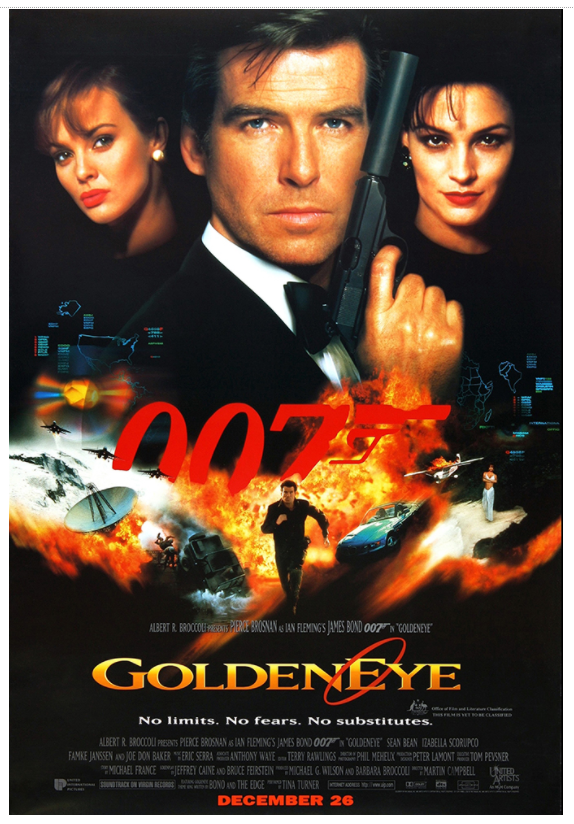

In [20]:
movie_df[movie_df.item_id.isin([2])]

item_id       movie title release date  video release date  \
1        2  GoldenEye (1995)  01-Jan-1995                 NaN   

                                            IMDb URL  unknown  Action  \
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   

   Adventure  Animation  Children  ...  Fantasy  Film-Noir  Horror  Musical  \
1          1          0         0  ...        0          0       0        0   

   Mystery  Romance  Sci-Fi  Thriller  War  Western  
1        0        0       0         1    0        0  

[1 rows x 24 columns]

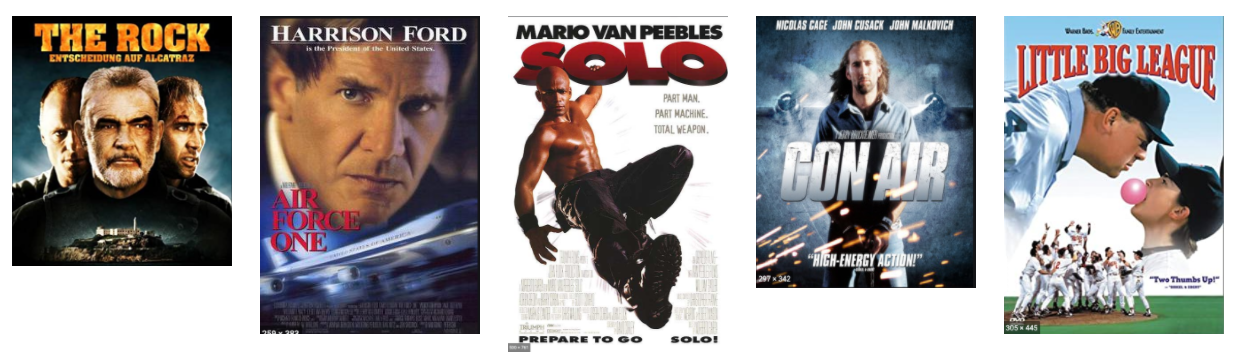

In [22]:
movie_df[movie_df.item_id.isin([300, 1016, 117, 1032, 976])]

item_id               movie title release date  video release date  \
116       117          Rock, The (1996)  07-Jun-1996                 NaN   
299       300      Air Force One (1997)  01-Jan-1997                 NaN   
975       976               Solo (1996)  23-Aug-1996                 NaN   
1015     1016            Con Air (1997)  06-Jun-1997                 NaN   
1031     1032  Little Big League (1994)  01-Jan-1994                 NaN   

                                               IMDb URL  unknown  Action  \
116   http://us.imdb.com/M/title-exact?Rock,%20The%2...        0       1   
299   http://us.imdb.com/M/title-exact?Air+Force+One...        0       1   
975      http://us.imdb.com/M/title-exact?Solo%20(1996)        0       1   
1015  http://us.imdb.com/M/title-exact?Con%20Air%20%...        0       1   
1031  http://us.imdb.com/M/title-exact?Little%20Big%...        0       0   

      Adventure  Animation  Children  ...  Fantasy  Film-Noir  Horror  \
116           1          0         0  ...        0          0       0   
299           0          0         0  ...        0          0       0   
975           0          0         0  ...        0          0       0   
1015          1          0         0  ...        0          0       0   
1031          0          0         1  ...        0          0       0   

      Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
116         0        0        0       0         1    0        0  
299         0        0        0       0         1    0        0  
975         0        0        0       1         1    0        0  
1015        0        0        0       0         1    0        0  
1031        0        0        0       0         0    0        0  

[5 rows x 24 columns]

### 3. Talk about the results

We can see that in section 1 the items that were chosen are similar and if we check it by genres - we see the success.
For "Toy Story", almost all movies were, 1 genre away from matching the toy story, out of 18(!)
Regarding "GoldenEye", for all 5 movies - all 18 genres were a match(!)

It's easy to understand why: When you have a vector of binary values, every "wrong" match, changes the cosine similarity to a very different value.
Looking at the results, almost all movies are Disney movies, 3/5 are cartoons, and all are clearly for kids.
For "GoldenEye" - all movies are thrillers/action-packed movies.

For "GoldenEye", all movies were a big hits in cinema, for Toy Story one (Aladdin). it's easy to understand why this happened.
This is not what the model is trying to find.

When we look at the results of the matrix factorization.
First, the results of genre match are much worse. For "Toy Story", one of the matched movies has mismatch on half of his genres, while for "GoldenEye" only 5 were mismatch in one of the movies.

Another iteresting thing is the results themselves: This time, the model chose "similar items": "Jurrasic park", a "Star Wars" movie, and "Conehead" as a match for "Toy Story".
At first glance, nothing is similar, until you consider what it's trying to predict. 
It's trying to predict that: "If you like this movie, you will probably like these movies...", and it is right(!) - I would much rather watch any of the items in the MF list than sitting through "Air bud", "The story of a cross-bred Golden Retriever, who shoots basketball hoops"(?!?!)

Last, looking at "GoldenEye"'s picks by MF, we see mostly action movies like item2item similarity. In fact, two of the picks by the first model were also the picks by the MF model.

But if I compare the items left to right, where the most similar item is the leftmost item, we see the same items for the second pick, "Air Force One", but of course, I would much prefer to see "The rock" - first pick of the MF model - than "Twister".

***
***
# Question 2: Content-based recommendation (60 points)

#### a. Build a function that recommends 5 most-relevant items to a user.

In [34]:
# Binary option should be set to True if the rating should be binary.
# It should be set to True for the first approach and False for the second approach
BINARY_OPTION = False
# NEGATIVE WEIGHT is relevant only for the first approach
NEGATIVE_WEIGHT = 0.25

def brating(row):
    if row['rating'] >= 3:
        val = 1
    elif row['rating'] >= 0:
        val = -NEGATIVE_WEIGHT
    else:
        val = row['rating']
    
    return val


ratings['binary_rating'] = ratings.apply(brating, axis=1)


if BINARY_OPTION:
    rating_column = 'binary_rating'
else:
    rating_column = 'rating'

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [30]:
# user profile
user_id_1 = 900

# train
train_user_x_movie_df = pd.pivot_table(train_ratings, values=rating_column, index=['item_id'], columns = ['user_id'])
train_user_x_movie_df.sort_index(axis=0, inplace=True)
train_userIDs = train_user_x_movie_df.columns
train_user_profile_df = pd.DataFrame(columns = movie_profile_df.columns)

for i in range(len(train_user_x_movie_df.columns)):
    working_df = movie_profile_df.mul(train_user_x_movie_df.iloc[:,i], axis=0)
    train_user_profile_df.loc[train_userIDs[i]] = working_df.mean(axis=0)

train/test

# # tests    
# test_user_x_movie_df = pd.pivot_table(test_ratings, values=rating_column, index=['item_id'], columns = ['user_id'])
# test_user_x_movie_df.sort_index(axis=0, inplace=True)
# test_userIDs = test_user_x_movie_df.columns
# test_user_profile_df = pd.DataFrame(columns = movie_profile_df.columns)

# for i in range(len(user_x_movie_df.columns)):
#     working_df = movie_profile_df.mul(user_x_movie_df.iloc[:,i], axis=0)
#     test_user_profile_df.loc[test_userIDs[i]] = working_df.mean(axis=0)



cosine_similarity_user_item = cosine_similarity(train_user_profile_df, movie_profile_df)
predict_most_similar_items_per_movie(cosine_similarity_user_item, train_user_profile_df, test_movie_profile_df, user_id_1, exclude_if_item_match=False)

NameError: name 'rating_column' is not defined

##### test_movie_profile_df --> The 10 movies' IDs that we deleted their rating from the rating matrix

In [33]:
user_profile_df

NameError: name 'user_profile_df' is not defined

In [ ]:
movie_id_1

In [ ]:
[337, 1526, 311, 1424, 517]

In [ ]:
for (c, v) in user_profile_df.loc[[900]].iteritems():
    print(c, v.values)

In [ ]:
movie_profile_df.loc[[337]]

In [ ]:
user_values = []
for (movie_g, movie_v), (user_g, user_v) in zip(movie_profile_df.loc[[337]].iteritems(), user_profile_df.loc[[900]].iteritems()):
    user_values.append((user_g, float(user_v.values[0])))

user_values_sorted = sorted(user_values, key=lambda x: x[1], reverse=True)
user_values_sorted

In [ ]:
for (movie_g, movie_v), (user_g, user_v) in zip(movie_profile_df.loc[[517]].iteritems(), user_profile_df.loc[[900]].iteritems()):
    print(f'Colunm Name: {movie_g} {movie_v.values[0]}, {user_v.values[0]}')

In [ ]:
# go over the movies and see that the genre

### b. Test your recommender system on 2 users. Explain your results.

### c. Use the MRR metric to evaluate your recommender system on the test set. Use a cutoff value of 5.

In [ ]:
MAX_COLUMNS_CUTOFF = 5
RATING_THRESHOLD_VALUE = 3


def get_mrr(pred, actual):
    """
    Mean Reciprocal Rank
    
    Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    matrix = get_relevant_item_matches_matrix_per_user(pred, actual)
    matrix = (np.asarray(r).nonzero()[0] for r in matrix)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in matrix])


def sort_user_ratings(row):
    '''Find the indices of the maximal values in given array'''
    return row.argsort()[-5:][::-1]


def get_relevant_item_matches_matrix_per_user(pred_matrix, actual_matrix):
    top_values_indices = np.apply_along_axis(sort_user_ratings, 1, actual_matrix)
    result = np.zeros_like(top_values_indices)
    rows = len(top_values_indices)
    columns = np.minimum(len(top_values_indices[0]), ≈)
    
    for i in range(rows):
        for j in range(columns):
            match = actual_matrix[i][top_values_indices[i][j]] >= RATING_THRESHOLD_VALUE and pred_matrix[i][top_values_indices[i][j]] >= RATING_THRESHOLD_VALUE
            
            if match:
                result[i][j] = 1
                break
    
    return result

get_mrr()

#### d. Compare the results of the content based recommender system to the matrix factorization recommender system using the same train and test set. Use the MRR metric for the comparison. 

#### e. Discuss the advantages and disadvantages of matrix factorization vs. content based recommender systems (refer to accuracy, complexity, explainaiblity and new user\new items) and when will you recommend using each approach. 

By using the <u>**MF model**</u>, recommendations are based on **similar users'** taste (User-2-User).<br>
For example, by rating a movie it finds another user, U, that gave a similar rating to that movie and recommends a second movie that U liked.<br>

**Disadvantages**: 
* This can be problematic and inaccurate if 2 users happen to like the same action movies, but their taste regarding horror movies is completely different. The system will predict similar ratings on horror movies for both users, and it will make the system look unreliable.<br>
* Moreover, this model tends to predict high ratings to popular movies becasue many users like these (by definition of "popular"), so recommending these is obvious and not useful, but it's difficult to predict a rating to an unpopular movie (not many rating are available).<br>
* Cold start: The system needs enough users and enugh ratings for items to be able to predict useful ratings.
* Popularity-bias: It's hard to recommend an item to a user with a unique taste, simply becasue there aren't many users to compare him to.
* A user may not understand why the system predicted a certain item - if it's not in the domain he is usually looking in.
* This is not considering the context in which the user chooses certain items - i.e watching a movie with friends/alone

**Advantages**: 
* When there are many movie ratings and many users that gave ratings (a dense matrix), the recommendations can be more accurate and the system is more rich with predictions (on many items in many domains).

**Complexity**: O(m*n) - number of items * users<br>
The problem is that every now and then (when there are more and more items/user ratings), the systems needs to compute new recommendations predictions because there is more data to rely on (Nearest neighbor algorithms require computations that grows with both the number of customers and products).

**It is recommended to use this model when there are many users and items' ratings: It will be more hollistic and will be better at suggesting items the users would not consider purchasing before ---> more engagement of users = more sales for the business**

---

With <u>**Content-based**</u> systems, recommendations are based on **similar items'** features (Item-2-Item).<br>
Recommend items similar to those a user has liked in the past - no other users are needed here.<br>

**Disadvantages**: 
* Improvement rate is slow since it requires many ratings by the user
* Superficiality: The system might predict more and more items in the same domain, and the user may not broden his horizons and explore different items (will only watch action movies, and will not buy items from different departments - this is very bad for business if you are not engaging with all its products and buy less overall)
* This is not considering the context in which the user chooses certain items - i.e watching a movie with friends/alone

**Advantages**:
* Easy to explain why the system predicted that a user will like/dislike a specific item.
* Better accuracy and quality of recommendations - fits your taste, even if you have a unique one.
* Cold start: It DOESN'T MATTER if an item is unpopular or even COMPLETELY NEW - its features are what's really matter and if you like/dislike a similar item, the systems predicts your rating for this one easily.
* In most cases, there are more ratings per item than per user.

**Complexity**: O(m) - number of items<br>
The system only needs user's previous item ratings to predict a new recommended item.

**It is recommended to use this model when there are many more items than users, and when there are not enough ratings per item because based on a user's taste, the system only looks at similar items by features.**